# **Predicción del precio de Bitcoin con Python**

In [221]:
pip install cryptocmd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [222]:
pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Datos**

In [223]:
#Tratamiento de datos
import pandas as pd
import numpy as np
import seaborn as sns
import calendar
import datetime
from cryptocmd import CmcScraper
#graficos
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go

In [224]:
#Descargar btc
scraper=CmcScraper('BTC','28-04-2013','27-03-2023')

In [225]:
df=scraper.get_dataframe()
df.sort_values(by='Date',ascending=True,inplace=True)

In [226]:
pd.set_option('display.max_columns',None)
display(df)
pd.reset_option('display.max_columns')

,Date,Open,High,Low,Close,Volume,Market Cap
3620,2013-04-28,135.300003,135.979996,132.100006,134.210007,0.000000e+00,1.488567e+09
3619,2013-04-29,134.444000,147.488007,134.000000,144.539993,0.000000e+00,1.603769e+09
3618,2013-04-30,144.000000,146.929993,134.050003,139.000000,0.000000e+00,1.542813e+09
3617,2013-05-01,139.000000,139.889999,107.720001,116.989998,0.000000e+00,1.298955e+09
3616,2013-05-02,116.379997,125.599998,92.281898,105.209999,0.000000e+00,1.168517e+09
...,...,...,...,...,...,...,...
4,2023-03-23,27301.957494,28729.843470,27183.363741,28333.972711,2.422043e+10,5.475907e+11
3,2023-03-24,28324.111695,28388.437746,27039.265432,27493.285144,2.598031e+10,5.313710e+11
2,2023-03-25,27487.337738,27791.825603,27196.233830,27494.706878,1.338301e+10,5.314240e+11
1,2023-03-26,27495.523958,28178.144437,27445.046355,27994.329514,1.387836e+10,5.411061e+11


In [227]:
#Cambiar el formato de la fecha
df['Date']=pd.to_datetime(df['Date'],format='%Y-%m-%d %H:%M:%S')
df=df.loc[:,['Date','Open', 'Close', 'High', 'Low']]
df=df.set_index('Date')
df=df.asfreq('D') #frecuencia diaria
df=df.sort_index()

In [228]:
df.head()

,Open,Close,High,Low
Date,,,,
2013-04-28,135.300003,134.210007,135.979996,132.100006
2013-04-29,134.444000,144.539993,147.488007,134.000000
2013-04-30,144.000000,139.000000,146.929993,134.050003
2013-05-01,139.000000,116.989998,139.889999,107.720001
2013-05-02,116.379997,105.209999,125.599998,92.281898


In [229]:
#Comprobamos si existeng valores nulos
df.isnull().sum()

Open     0
Close    0
High     0
Low      0
dtype: int64

In [230]:
df.isnull().any(axis=1).mean()

0.0

## **Halving del Bitcoin como variable exógena**

* El "halving" o "reducción a la mitad" del Bitcoin es un evento programado que ocurre aproximadamente cada cuatro años y que reduce a la mitad la recompensa que reciben los mineros de Bitcoin por verificar transacciones y agregar nuevos bloques a la cadena de bloques de Bitcoin. Este evento tiene un efecto significativo en la oferta de Bitcoin en el mercado, lo que a su vez puede tener un impacto en el precio del Bitcoin.


* Cuando ocurre el halving, la oferta de nuevos Bitcoins que entran en circulación se reduce a la mitad. Esto significa que hay menos Bitcoins disponibles para ser comprados en el mercado, lo que puede aumentar la demanda de Bitcoin si la cantidad de personas que quieren comprarlo sigue siendo la misma. Si la demanda de Bitcoin se mantiene constante o incluso aumenta mientras la oferta se reduce, esto puede conducir a un aumento en el precio del Bitcoin.


* En términos de la predicción de precios del Bitcoin, el halving puede considerarse una variable exógena, es decir, una variable que está fuera del control del modelo y que se utiliza para predecir el precio del Bitcoin. Dado que el halving es un evento programado y conocido de antemano, los analistas y los inversores pueden utilizar esta información para ajustar sus modelos de predicción del precio del Bitcoin y tener en cuenta el impacto del halving en la oferta y la demanda de Bitcoin.







In [231]:
btc_halving = {'halving'              : [0, 1 , 2, 3, 4],
               'date'                 : ['2009-01-03', '2012-11-28', 
                                         '2016-07-09', '2020-05-11', np.nan],
               'reward'               : [50, 25, 12.5, 6.25, 3.125],
               'halving_block_number' : [0, 210000, 420000 ,630000, 840000]
              }

[**Bloques Restantes**](https://academy.binance.com/es/halving)

In [232]:
bloques_restantes = 57048
bloques_por_dia = 144

In [233]:
dias = bloques_restantes / bloques_por_dia
dias

396.1666666666667

In [234]:
next_halving = pd.to_datetime('2023-03-27', format='%Y-%m-%d') + datetime.timedelta(days=dias)
next_halving = next_halving.replace(microsecond=0, second=0, minute=0, hour=0)
next_halving = next_halving.strftime('%Y-%m-%d')

In [235]:
btc_halving['date'][-1]=next_halving
print('El proximo halving ocurrica aproximadamente en:',{next_halving})

El proximo halving ocurrica aproximadamente en: {'2024-04-26'}


In [236]:
df['reward']=np.nan
df['countdown_halving']=np.nan

In [237]:
for i in range(len(btc_halving['halving'])-1):
  #fecha inicial y final de cada halving
  if btc_halving['date'][i] < df.index.min().strftime('%Y-%m-%d'):
    start_date=df.index.min().strftime('%Y-%m-%d')
  else:
    start_date=btc_halving['date'][i]

  end_date = btc_halving['date'][i+1]
  mask = (df.index >= start_date) & (df.index < end_date)
  #Rellenar columnas con la recompensa de la mineria
  df.loc[mask,'reward']=btc_halving['reward'][i]
  #Rellenar columna 'countdown_halving' con los días restantes
  time_to_next_halving = pd.to_datetime(end_date) - pd.to_datetime(start_date)
  df.loc[mask,'countdown_halving']= np.arange(time_to_next_halving.days)[::-1][:mask.sum()]


In [238]:
df.columns

Index(['Open', 'Close', 'High', 'Low', 'reward', 'countdown_halving'], dtype='object')

In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3621 entries, 2013-04-28 to 2023-03-27
Freq: D
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               3621 non-null   float64
 1   Close              3621 non-null   float64
 2   High               3621 non-null   float64
 3   Low                3621 non-null   float64
 4   reward             3621 non-null   float64
 5   countdown_halving  3621 non-null   float64
dtypes: float64(6)
memory usage: 198.0 KB


In [240]:
df.isnull().sum()

Open                 0
Close                0
High                 0
Low                  0
reward               0
countdown_halving    0
dtype: int64

In [241]:
df.sample(20)

,Open,Close,High,Low,reward,countdown_halving
Date,,,,,,
2021-07-30,40027.483320,42235.547709,42235.547709,38397.354510,6.25,1000.0
2022-12-05,17128.894080,16974.825665,17378.153310,16922.431869,6.25,507.0
2016-04-21,441.415985,449.424988,450.548004,440.951996,25.00,78.0
2017-12-14,16384.599609,16564.000000,17085.800781,16185.900391,12.50,878.0
2019-01-09,4031.552016,4035.296369,4068.403581,4022.662809,12.50,487.0
2015-07-20,273.498993,278.980988,278.980988,272.959991,25.00,354.0
2016-05-30,528.471008,533.864014,544.348999,522.963013,25.00,39.0
2014-02-08,699.570007,673.919983,721.820007,661.869995,25.00,881.0
2014-10-05,328.915985,320.510010,341.800995,289.295990,25.00,642.0


In [242]:
#Comprobar que se ha creado
print('Segundo halving:', btc_halving['date'][2])
display(df.loc['2016-07-08':'2016-07-09'])
print('')
print('Tercer halving:', btc_halving['date'][3])
display(df.loc['2020-05-10':'2020-05-11'])
print('')
print('Próximo halving:', btc_halving['date'][4])

Segundo halving: 2016-07-09


,Open,Close,High,Low,reward,countdown_halving
Date,,,,,,
2016-07-08,640.687988,666.523010,666.706970,636.466980,25.0,0.0
2016-07-09,666.383972,650.960022,666.383972,633.398987,12.5,1401.0



Tercer halving: 2020-05-11


,Open,Close,High,Low,reward,countdown_halving
Date,,,,,,
2020-05-10,9591.169231,8756.431142,9595.580629,8395.107451,12.50,0.0
2020-05-11,8755.535639,8601.796202,9033.471176,8374.322975,6.25,1445.0



Próximo halving: 2024-04-26


In [243]:
df.tail(2)

,Open,Close,High,Low,reward,countdown_halving
Date,,,,,,
2023-03-26,27495.523958,27994.329514,28178.144437,27445.046355,6.25,396.0
2023-03-27,27994.067923,27139.888531,28037.925861,26606.689001,6.25,395.0


## **EDA (Analisis Exploratorio de los Datos)**

In [244]:
#Grafico de velas japonesas
candlestick = go.Candlestick(
                  x     = df.index,
                  open  = df['Open'],
                  close = df['Close'],
                  low   = df['Low'],
                  high  = df['High'],
              )

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width       = 900,
    height      = 450,
    title       = dict(text='<b>Chart Bitcoin/USD</b>', font=dict(size=30)),
    yaxis_title = dict(text='Precio (USD)', font=dict(size=15)),
    margin      = dict(l=10, r=20, t=80, b=20),
    shapes      = [dict(x0=btc_halving['date'][2], x1=btc_halving['date'][2], 
                        y0=0, y1=1, xref='x', yref='paper', line_width=2),
                   dict(x0=btc_halving['date'][3], x1=btc_halving['date'][3], 
                        y0=0, y1=1, xref='x', yref='paper', line_width=2),
                   dict(x0=btc_halving['date'][4], x1=btc_halving['date'][4], 
                        y0=0, y1=1, xref='x', yref='paper', line_width=2)
                  ],
    annotations = [dict(x=btc_halving['date'][2], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Segundo halving'),
                   dict(x=btc_halving['date'][3], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Tercer halving'),
                   dict(x=btc_halving['date'][4], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Cuarto halving')
                  ],
    xaxis_rangeslider_visible = False,
)

fig.show()

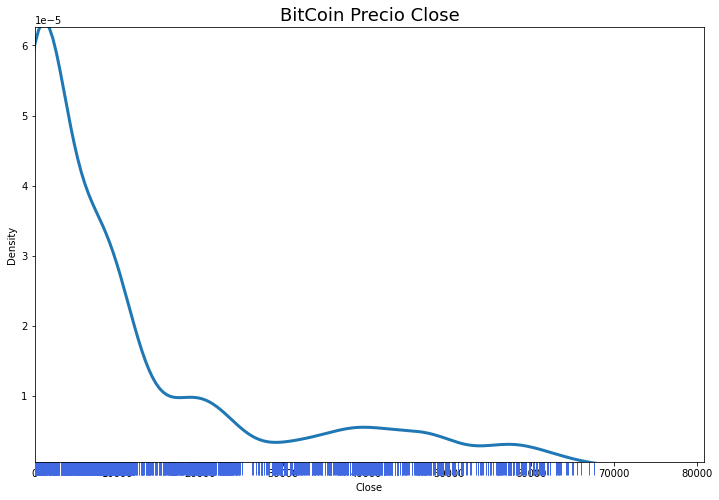

In [245]:
#Distribucion normal
fig,ax=plt.subplots(figsize=(12,8))
p=sns.kdeplot(data=df,x='Close',linewidth=3,ax=ax)
r=sns.rugplot(data=df,x='Close',ax=ax,c='royalblue',
              height=-.03,clip_on=False)
p.set(xlim=(0,None))
p.set_title('BitCoin Precio Close',fontsize=18)
plt.show()

## **Graficos de Autocorrrelacion**

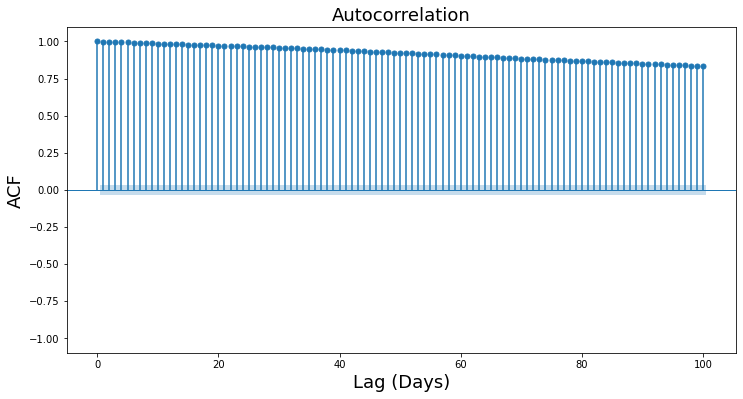

In [246]:
#Lags de 100
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(df['Close'],lags=100,bartlett_confint=False,ax=ax,linewidth=1)
plt.ylabel("ACF",fontsize=18)
plt.xlabel("Lag (Days)",fontsize=18)
ax.set_ylim(-1.1, 1.1)
plt.title('Autocorrelation',fontsize=18)
fig.show()

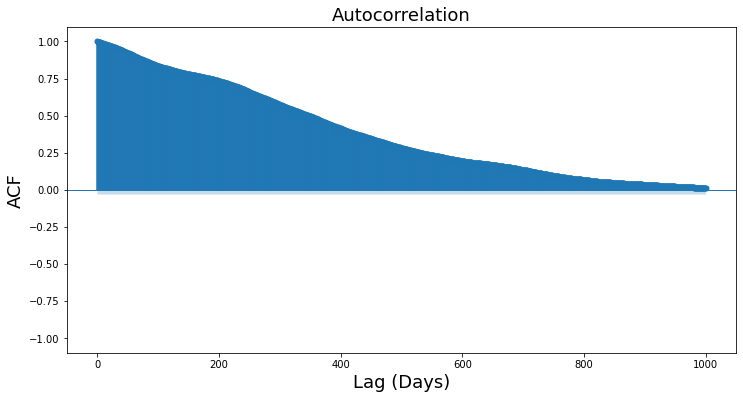

In [247]:
#Lags de 1000
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(df['Close'],lags=1000,bartlett_confint=False,ax=ax,linewidth=1)
plt.ylabel("ACF",fontsize=18)
plt.xlabel("Lag (Days)",fontsize=18)
ax.set_ylim(-1.1, 1.1)
plt.title('Autocorrelation',fontsize=18)
fig.show()

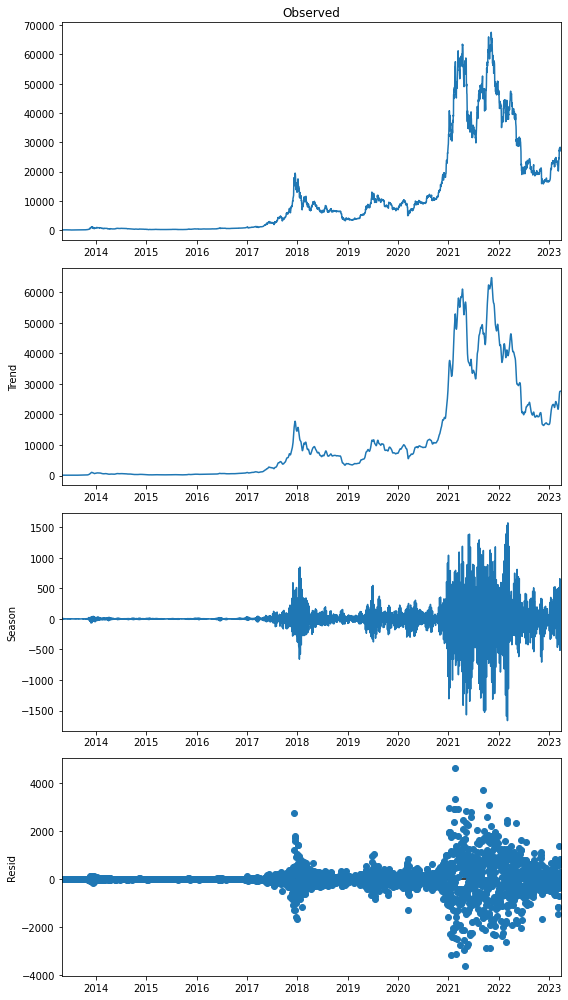

In [248]:
from statsmodels.tsa.seasonal import STL
import matplotlib as mpl
stl_model = STL(df[["Close"]], period=7, seasonal=7).fit()
with mpl.rc_context():
    mpl.rc("figure", figsize=(8, 14))
    stl_model.plot()
    plt.tight_layout()

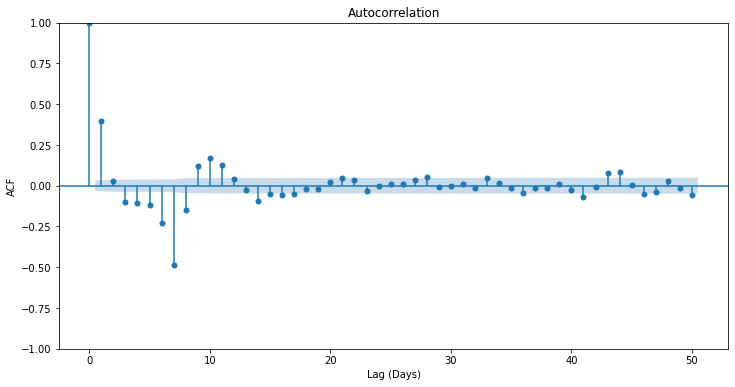

In [249]:
# Residual
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(stl_model.resid.dropna(), lags=50,ax=ax)
plt.ylabel("ACF")
plt.xlabel("Lag (Days)")
plt.show()

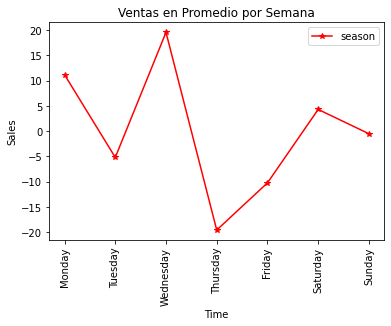

In [272]:
seasonal = stl_model.seasonal.groupby(stl_model.seasonal.index.day_of_week).mean()
seasonal.plot.line(xlabel="Time", ylabel="Sales", marker="*",color='red',title='Ventas en Promedio por Semana')
plt.xticks(range(0, 7), calendar.day_name[0:], rotation="vertical")
plt.legend()
plt.show();

## **Baseline - Simulación Teoría del paseo aleatorio (Random Walk)**

* La Baseline (o línea base en español) en la teoría del paseo aleatorio (Random Walk) se refiere a un valor de referencia que se utiliza para comparar con los resultados obtenidos a partir de un modelo de simulación.


* La Baseline se utiliza a menudo como punto de partida para evaluar el impacto de diferentes variables o factores en el resultado de la simulación. Al comparar los resultados obtenidos con la Baseline, se puede determinar si una variable en particular tiene un efecto significativo sobre el proceso simulado.

* En resumen, la Baseline en la teoría del paseo aleatorio se refiere a un valor de referencia utilizado para comparar los resultados obtenidos a partir de un modelo de simulación y evaluar el impacto de diferentes variables o factores en el resultado del proceso simulado.

In [251]:
inicio_train = '2020-01-01 00:00:00'
fin_train='2022-06-30 23:59:59'

In [252]:
print(f"Serie temporal completa : {df.index.min()} --- {df.index.max()}  (n={len(df)})")
print(f"Fechas train            : {df.loc[inicio_train:fin_train].index.min()} --- {df.loc[inicio_train:fin_train].index.max()}  (n={len(df.loc[inicio_train:fin_train])})")
print(f"Fechas test             : {df.loc[fin_train:].index.min()} --- {df.loc[fin_train:].index.max()}  (n={len(df.loc[fin_train:])})")

Serie temporal completa : 2013-04-28 00:00:00 --- 2023-03-27 00:00:00  (n=3621)
Fechas train            : 2020-01-01 00:00:00 --- 2022-06-30 00:00:00  (n=912)
Fechas test             : 2022-07-01 00:00:00 --- 2023-03-27 00:00:00  (n=270)


**Simulacion RandomWalk**

In [253]:
df.head()

,Open,Close,High,Low,reward,countdown_halving
Date,,,,,,
2013-04-28,135.300003,134.210007,135.979996,132.100006,25.0,1167.0
2013-04-29,134.444000,144.539993,147.488007,134.000000,25.0,1166.0
2013-04-30,144.000000,139.000000,146.929993,134.050003,25.0,1165.0
2013-05-01,139.000000,116.989998,139.889999,107.720001,25.0,1164.0
2013-05-02,116.379997,105.209999,125.599998,92.281898,25.0,1163.0


In [254]:
df_rw=df['Close'].copy()

In [255]:
df_rw=pd.DataFrame(df_rw,columns=['Close'])
df_rw.columns

Index(['Close'], dtype='object')

In [256]:
df_rw['pred_close']=df_rw['Close'].shift(1)

In [257]:
df_rw.head()

,Close,pred_close
Date,,
2013-04-28,134.210007,NaN
2013-04-29,144.539993,134.210007
2013-04-30,139.000000,144.539993
2013-05-01,116.989998,139.000000
2013-05-02,105.209999,116.989998


In [258]:
from sklearn.metrics import mean_absolute_error

In [259]:
#Error de test
y_true = df_rw.loc[fin_train:, 'Close']
y_pred = df_rw.loc[fin_train:, 'pred_close']
metrica = mean_absolute_error(y_true, y_pred)

print(f'Error de test: {metrica}')
display(df_rw.loc[fin_train:,].head(4))

Error de test: 404.2631249640507


,Close,pred_close
Date,,
2022-07-01,19269.366686,19784.726495
2022-07-02,19242.255580,19269.366686
2022-07-03,19297.076083,19242.255580
2022-07-04,20231.261512,19297.076083


**Grafico Random Walk**

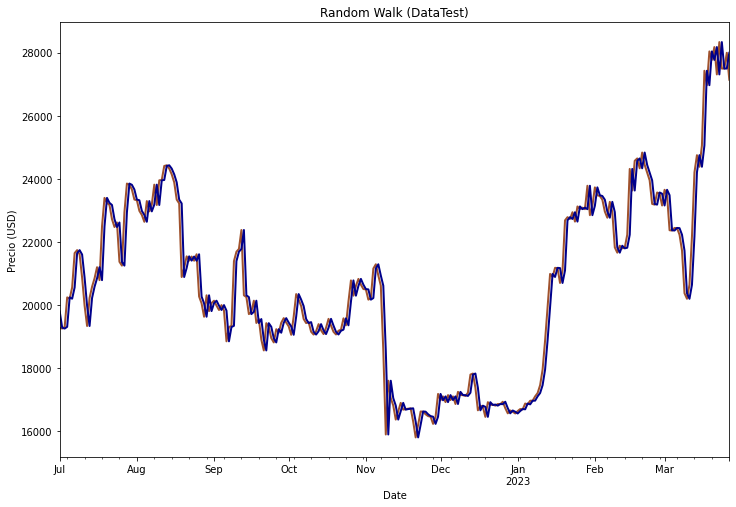

In [260]:
#Grafico
fig,ax=plt.subplots(figsize=(12,8))
df_rw.loc[fin_train:, 'Close'].plot(ax=ax, linewidth=2, label='Datos Test',
                                    c='sienna')
df_rw.loc[fin_train:, 'pred_close'].plot(ax=ax, linewidth=2, label='Pred Test',
                                    c='darkblue')
ax.set_title('Random Walk (DataTest)')
ax.set_ylabel('Precio (USD)')
plt.show()

In [261]:
#DataFrame
df_errores=pd.DataFrame({'modelo': 'Base - Random Walk', 'lags': 1, 
                           'error_test': metrica, 'variables_exog': False},
                          index=[0])
df_errores

,modelo,lags,error_test,variables_exog
0,Base - Random Walk,1,404.263125,False


In [262]:
# Backtest forecasters con diferentes lags
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from lightgbm import LGBMRegressor
lags=[1,7,30]
metricas=[]
predicciones_list=[]

In [263]:
for lag in lags:
    
    # Crear forecaster
    forecaster = ForecasterAutoreg(
                     regressor     = LGBMRegressor(random_state=123),
                     lags          = lag,
                     transformer_y = None
                 )
    
    # Backtest test data 1 step
    metrica, predicciones = backtesting_forecaster(
                                forecaster         = forecaster,
                                y                  = df.loc[inicio_train:, 'Close'],
                                initial_train_size = len(df.loc[inicio_train:fin_train, 'Close']),
                                fixed_train_size   = True,
                                steps              = 1,
                                refit              = True,
                                metric             = 'mean_absolute_error',
                                verbose            = False
                            )
    
    metricas.append(metrica)
    predicciones_list.append(predicciones)

/usr/local/lib/python3.9/dist-packages/skforecast/model_selection/model_selection.py:370: RuntimeWarning:

The forecaster will be fit 270 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 


/usr/local/lib/python3.9/dist-packages/skforecast/model_selection/model_selection.py:370: RuntimeWarning:

The forecaster will be fit 270 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 


/usr/local/lib/python3.9/dist-packages/skforecast/model_selection/model_selection.py:370: RuntimeWarning:

The forecaster will be fit 270 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




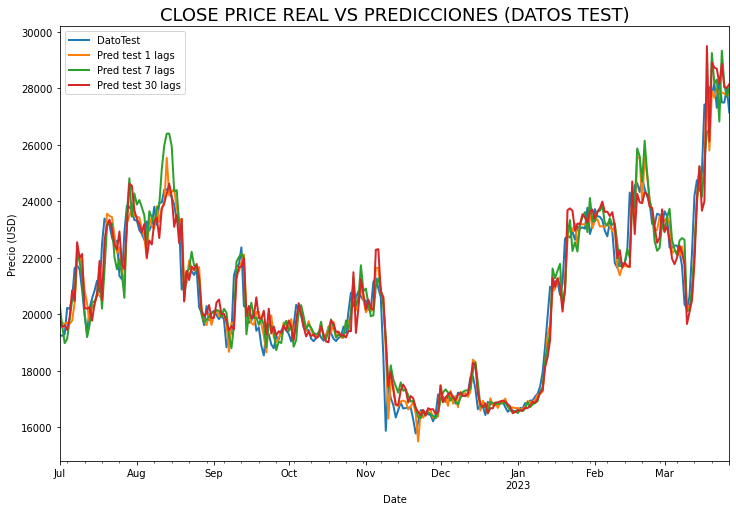

In [264]:
#Grafico 
#df.loc[fila_etiqueta, columna_etiqueta]
fig,ax=plt.subplots(figsize=(12,8))
df.loc[fin_train:,'Close'].plot(ax=ax,linewidth=2,label='DatoTest')
#Plot predicciones test para diferencias en el lags
for predicciones, lag in zip(predicciones_list,lags):
  predicciones=predicciones.rename(columns={'pred':f'Pred test {lag} lags'})
  predicciones.plot(ax=ax,linewidth=2)

ax.set_title('CLOSE PRICE REAL VS PREDICCIONES (DATOS TEST)',fontsize=18)
ax.set_ylabel('Precio (USD)')
plt.legend()
plt.show()

In [265]:
modelo='LGBMRegressor'
df_errores=pd.concat([
    df_errores,
    pd.DataFrame({'modelo':modelo,'lags':lags,
                  'error_test':metricas,'variables_exg':False})
    ]).reset_index(drop=True)
df_errores.sort_values(by='error_test')

,modelo,lags,error_test,variables_exog,variables_exg
0,Base - Random Walk,1,404.263125,False,NaN
1,LGBMRegressor,1,469.877517,NaN,False
3,LGBMRegressor,30,540.676446,NaN,False
2,LGBMRegressor,7,559.445726,NaN,False


Los errores de test (los cuales reflejan cómo de bien generaliza cada modelo) demuestran que ninguno de los modelos mejora el baseline a pesar de que se incorpore más información del pasado (número de lags). En vista de los resultados, se intentan otras alternativas como es la incorporación de variables exógenas a la serie.

## **Forecaster con variable exogenas**

In [266]:
df_1=df.copy()
df_1.head()

,Open,Close,High,Low,reward,countdown_halving
Date,,,,,,
2013-04-28,135.300003,134.210007,135.979996,132.100006,25.0,1167.0
2013-04-29,134.444000,144.539993,147.488007,134.000000,25.0,1166.0
2013-04-30,144.000000,139.000000,146.929993,134.050003,25.0,1165.0
2013-05-01,139.000000,116.989998,139.889999,107.720001,25.0,1164.0
2013-05-02,116.379997,105.209999,125.599998,92.281898,25.0,1163.0


In [267]:
df_1['mes']=df_1.index.month
df_1['mes']=df_1['mes'].astype('category')
df_1['reward']=df_1['reward'].astype('category')

In [268]:
#one hot encoding
df_1=pd.get_dummies(df_1,columns=['reward', 'mes'])
df_1.head()

,Open,Close,High,Low,countdown_halving,reward_6.25,reward_12.5,reward_25.0,mes_1,mes_2,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12
Date,,,,,,,,,,,,,,,,,,,,
2013-04-28,135.300003,134.210007,135.979996,132.100006,1167.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2013-04-29,134.444000,144.539993,147.488007,134.000000,1166.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2013-04-30,144.000000,139.000000,146.929993,134.050003,1165.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2013-05-01,139.000000,116.989998,139.889999,107.720001,1164.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2013-05-02,116.379997,105.209999,125.599998,92.281898,1163.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0


In [269]:
#selecionar las variables exogenas y incluidas por el one hot encoding
exog=[column for column in df_1.columns if column.startswith(('reward', 'mes'))]
exog.extend(['countdown_halving'])
exog

['reward_6.25',
 'reward_12.5',
 'reward_25.0',
 'mes_1',
 'mes_2',
 'mes_3',
 'mes_4',
 'mes_5',
 'mes_6',
 'mes_7',
 'mes_8',
 'mes_9',
 'mes_10',
 'mes_11',
 'mes_12',
 'countdown_halving']

In [270]:
# Backtest test data 1 step
metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = df_1.loc[inicio_train:, 'Close'],
                            exog               = df_1.loc[inicio_train:, exog],
                            initial_train_size = len(df_1.loc[inicio_train:fin_train, 'Close']),
                            fixed_train_size   = True,
                            steps              = 1,
                            refit              = True,
                            metric             = 'mean_absolute_error',
                            verbose            = False
                        )

/usr/local/lib/python3.9/dist-packages/skforecast/model_selection/model_selection.py:370: RuntimeWarning:

The forecaster will be fit 270 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




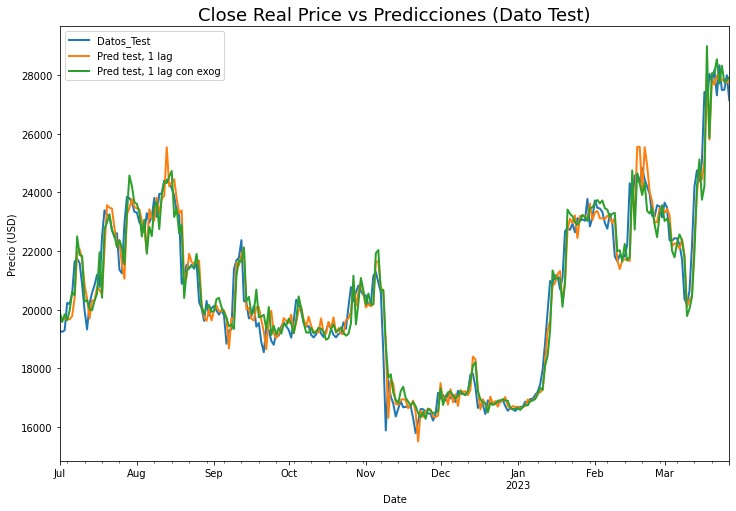

In [271]:
fig,ax=plt.subplots(figsize=(12,8))
df_1.loc[fin_train:,'Close'].plot(
    ax=ax,
    linewidth=2,
    label='Datos_Test'
)
#Plot prediciones 1 lag sin variable exogenas
predicciones_no_exog = predicciones_list[0].rename(columns={'pred': f'Pred test, 1 lag'})
predicciones_no_exog.plot(
    ax=ax,
    linewidth=2
)
#plot de predicciones 1 lag con variables exogenas
predicciones_exog=predicciones.rename(columns={'pred': f'Pred test, 1 lag con exog'})
predicciones_exog.plot(
    ax=ax,
    linewidth=2
)
#-----------------------------------------------------------------------
plt.title('Close Real Price vs Predicciones (Dato Test)',fontsize=18)
plt.ylabel('Precio (USD)')
plt.legend()
plt.show()

In [275]:
df_errores=pd.concat([
    df_errores,
    pd.DataFrame({'modelo':modelo,
                  'lags':1,
                  'error_test':metrica,
                  'variable_exog':True},
                 index=[4])
    ]).reset_index(drop=True)
df_errores.sort_values(by='error_test')

,modelo,lags,error_test,variables_exog,variables_exg,variable_exog
0,Base - Random Walk,1,404.263125,False,NaN,NaN
1,LGBMRegressor,1,469.877517,NaN,False,NaN
4,LGBMRegressor,1,493.022378,NaN,NaN,True
3,LGBMRegressor,30,540.676446,NaN,False,NaN
2,LGBMRegressor,7,559.445726,NaN,False,NaN


En este caso, incorporar variables exógenas aumenta ligeramente la capacidad predictiva del modelo pero, aún así, no se supera la del modelo base.